In [ ]:
!pip install torch torchvision scikit-learn
!pip install -q gradio

In [ ]:
import os
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score,precision_score,recall_score,confusion_matrix,ConfusionMatrixDisplay)
import numpy as np
from PIL import Image
import torch.nn.functional as F
import gradio as gr


In [ ]:

#unzips the data set
zippath = "/content/dataset_ready.zip"
extractpath = "/content/dataset_ready"
os.makedirs(extractpath, exist_ok=True)
with zipfile.ZipFile(zippath, 'r') as z:z.extractall(extractpath)


In [ ]:
dataroot = "/content/dataset_ready/Original Images"
transform = transforms.Compose([
transforms.Resize((244, 244)), #244=image size
transforms.RandomHorizontalFlip(p=0.5),
transforms.ColorJitter(brightness=0.15,contrast=0.15),#fitlers the pictures and makes them all equal of contrtast and brightness
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])##transforms the image from PIL 0-255 HxWxC to tensor 0-1 CxHxW
dataset = datasets.ImageFolder(root=dataroot, transform=transform)#pulls the class label from the sub folder and also automatically builds the data.setclasses in alphabetica order
#confirms if the label and slides are in the right folder with the right classes
print("Total classes:", len(dataset.classes))
print("Total images:", len(dataset))
print (dataset.classes[:5])


Total classes: 31
Total images: 2562
['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt', 'Amitabh Bachchan', 'Andy Samberg']


In [ ]:
#splitting the data for 80% trainng and then %20 for testing rabndomly

trainsize = int(0.8 * len(dataset))
testsize  = len(dataset) - trainsize

traindateset, testdataset = random_split(dataset, [trainsize, testsize])
#the model is trained using batchs and 16 for our batch size was the perfect size
batch_size = 16

train_loader = DataLoader(traindateset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(testdataset,  batch_size=batch_size, shuffle=False)
#our train size and test size
print("train size:", len(traindateset))
print("test size:", len(testdataset))


train size: 2049
test size: 513


In [ ]:
#tries to use gpu as the device if not then the cpu will work
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)#if cuda then its using gpu
numberclasses = len(dataset.classes)#number of people to predict
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) #CNN model resnet18 loaded and is already pretrained,also includes pooling along
# Freeze all pretrained layers so that their weight wont affect our dataset and oversamples them
for p in model.parameters():p.requires_grad = False
# Unfreeze only the last block of resnet layer4,we chose this block since it matches our need
for name, p in model.named_parameters():
  if "layer4" in name: p.requires_grad = True#allows us to use more layers of the pretrai
# replace classifier and move to device making output layer match number of classes
model.fc = nn.Linear(model.fc.in_features, numberclasses)
model = model.to(device)#moves the model to either the gpu or cpu
criterion = nn.CrossEntropyLoss()#our loss function
optimizer = optim.Adam((p for p in model.parameters() if p.requires_grad), lr=1e-4)#our optimizer,1e-4 is how fast the model is


cuda


In [ ]:
#right inference mode which is much faster and also uses less memeory
def evaluationmodel(model, loader):
    model.eval()
    predict = []
    labels = []
    #stops gradient calculation
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)#foward pass
            _, p = torch.max(out, 1)#finds the highest probability class
            predict.extend(p.cpu().numpy())
            labels.extend(y.cpu().numpy())
#metrics for model
    accuracy = accuracy_score(labels, predict)
    precision = precision_score(labels, predict, average='macro', zero_division=0)
    recall= recall_score(labels, predict, average='macro', zero_division=0)
    return accuracy, precision, recall


In [ ]:
#training loop using 5 epochs
epochs = 5
#stores the metrics for plotting
trainlos = []
validationaccuracy = []
validationprecision = []
validationrecall = []
#traning loop for each batch
#forward pass-compute loss-backprop-optimizerstep
for epoch in range(epochs):
    model.train()
    runingloss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
#create an instance of the ResNet18 class define the loss function and optimizer
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runingloss += loss.item() * imgs.size(0)

    #avarage loss over all the training images
    epoch_loss = runingloss / len(train_loader.dataset)
    acc, prec, rec = evaluationmodel(model, test_loader)
    trainlos.append(epoch_loss)
    validationaccuracy.append(acc)
    validationprecision.append(prec)
    validationrecall.append(rec)

    #summary line of each epoch
    print(
        f"Epoch {epoch+1}/5 -> "
        f"Training Loss: {epoch_loss:.4f}  "
        f"Accuracy: {acc:.4f}  "
        f"Precision: {prec:.4f}  "
        f"Recall: {rec:.4f}"
    )


Epoch 1/5 -> Training Loss: 2.4495  Accuracy: 0.5439  Precision: 0.5888  Recall: 0.5374
Epoch 2/5 -> Training Loss: 1.2103  Accuracy: 0.6686  Precision: 0.6763  Recall: 0.6643
Epoch 3/5 -> Training Loss: 0.6673  Accuracy: 0.6940  Precision: 0.7061  Recall: 0.6988
Epoch 4/5 -> Training Loss: 0.3651  Accuracy: 0.7368  Precision: 0.7384  Recall: 0.7271
Epoch 5/5 -> Training Loss: 0.1988  Accuracy: 0.7446  Precision: 0.7383  Recall: 0.7400


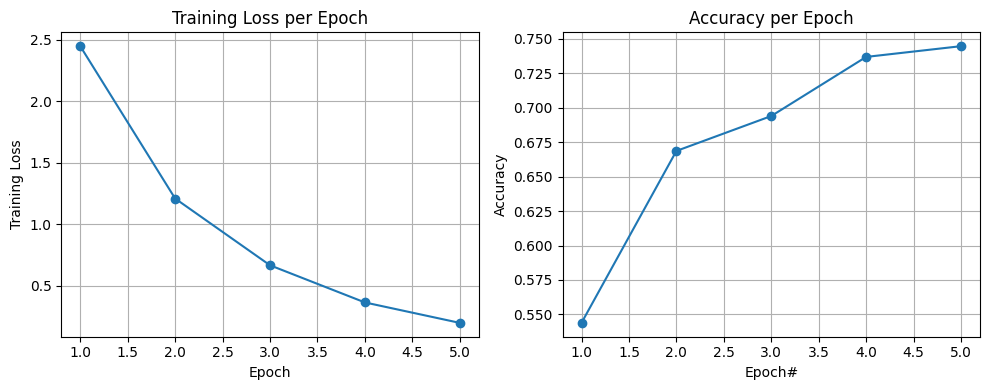

In [ ]:

epochsxy = range(1, len(trainlos)+1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochsxy, trainlos, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochsxy, validationaccuracy, marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch#")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


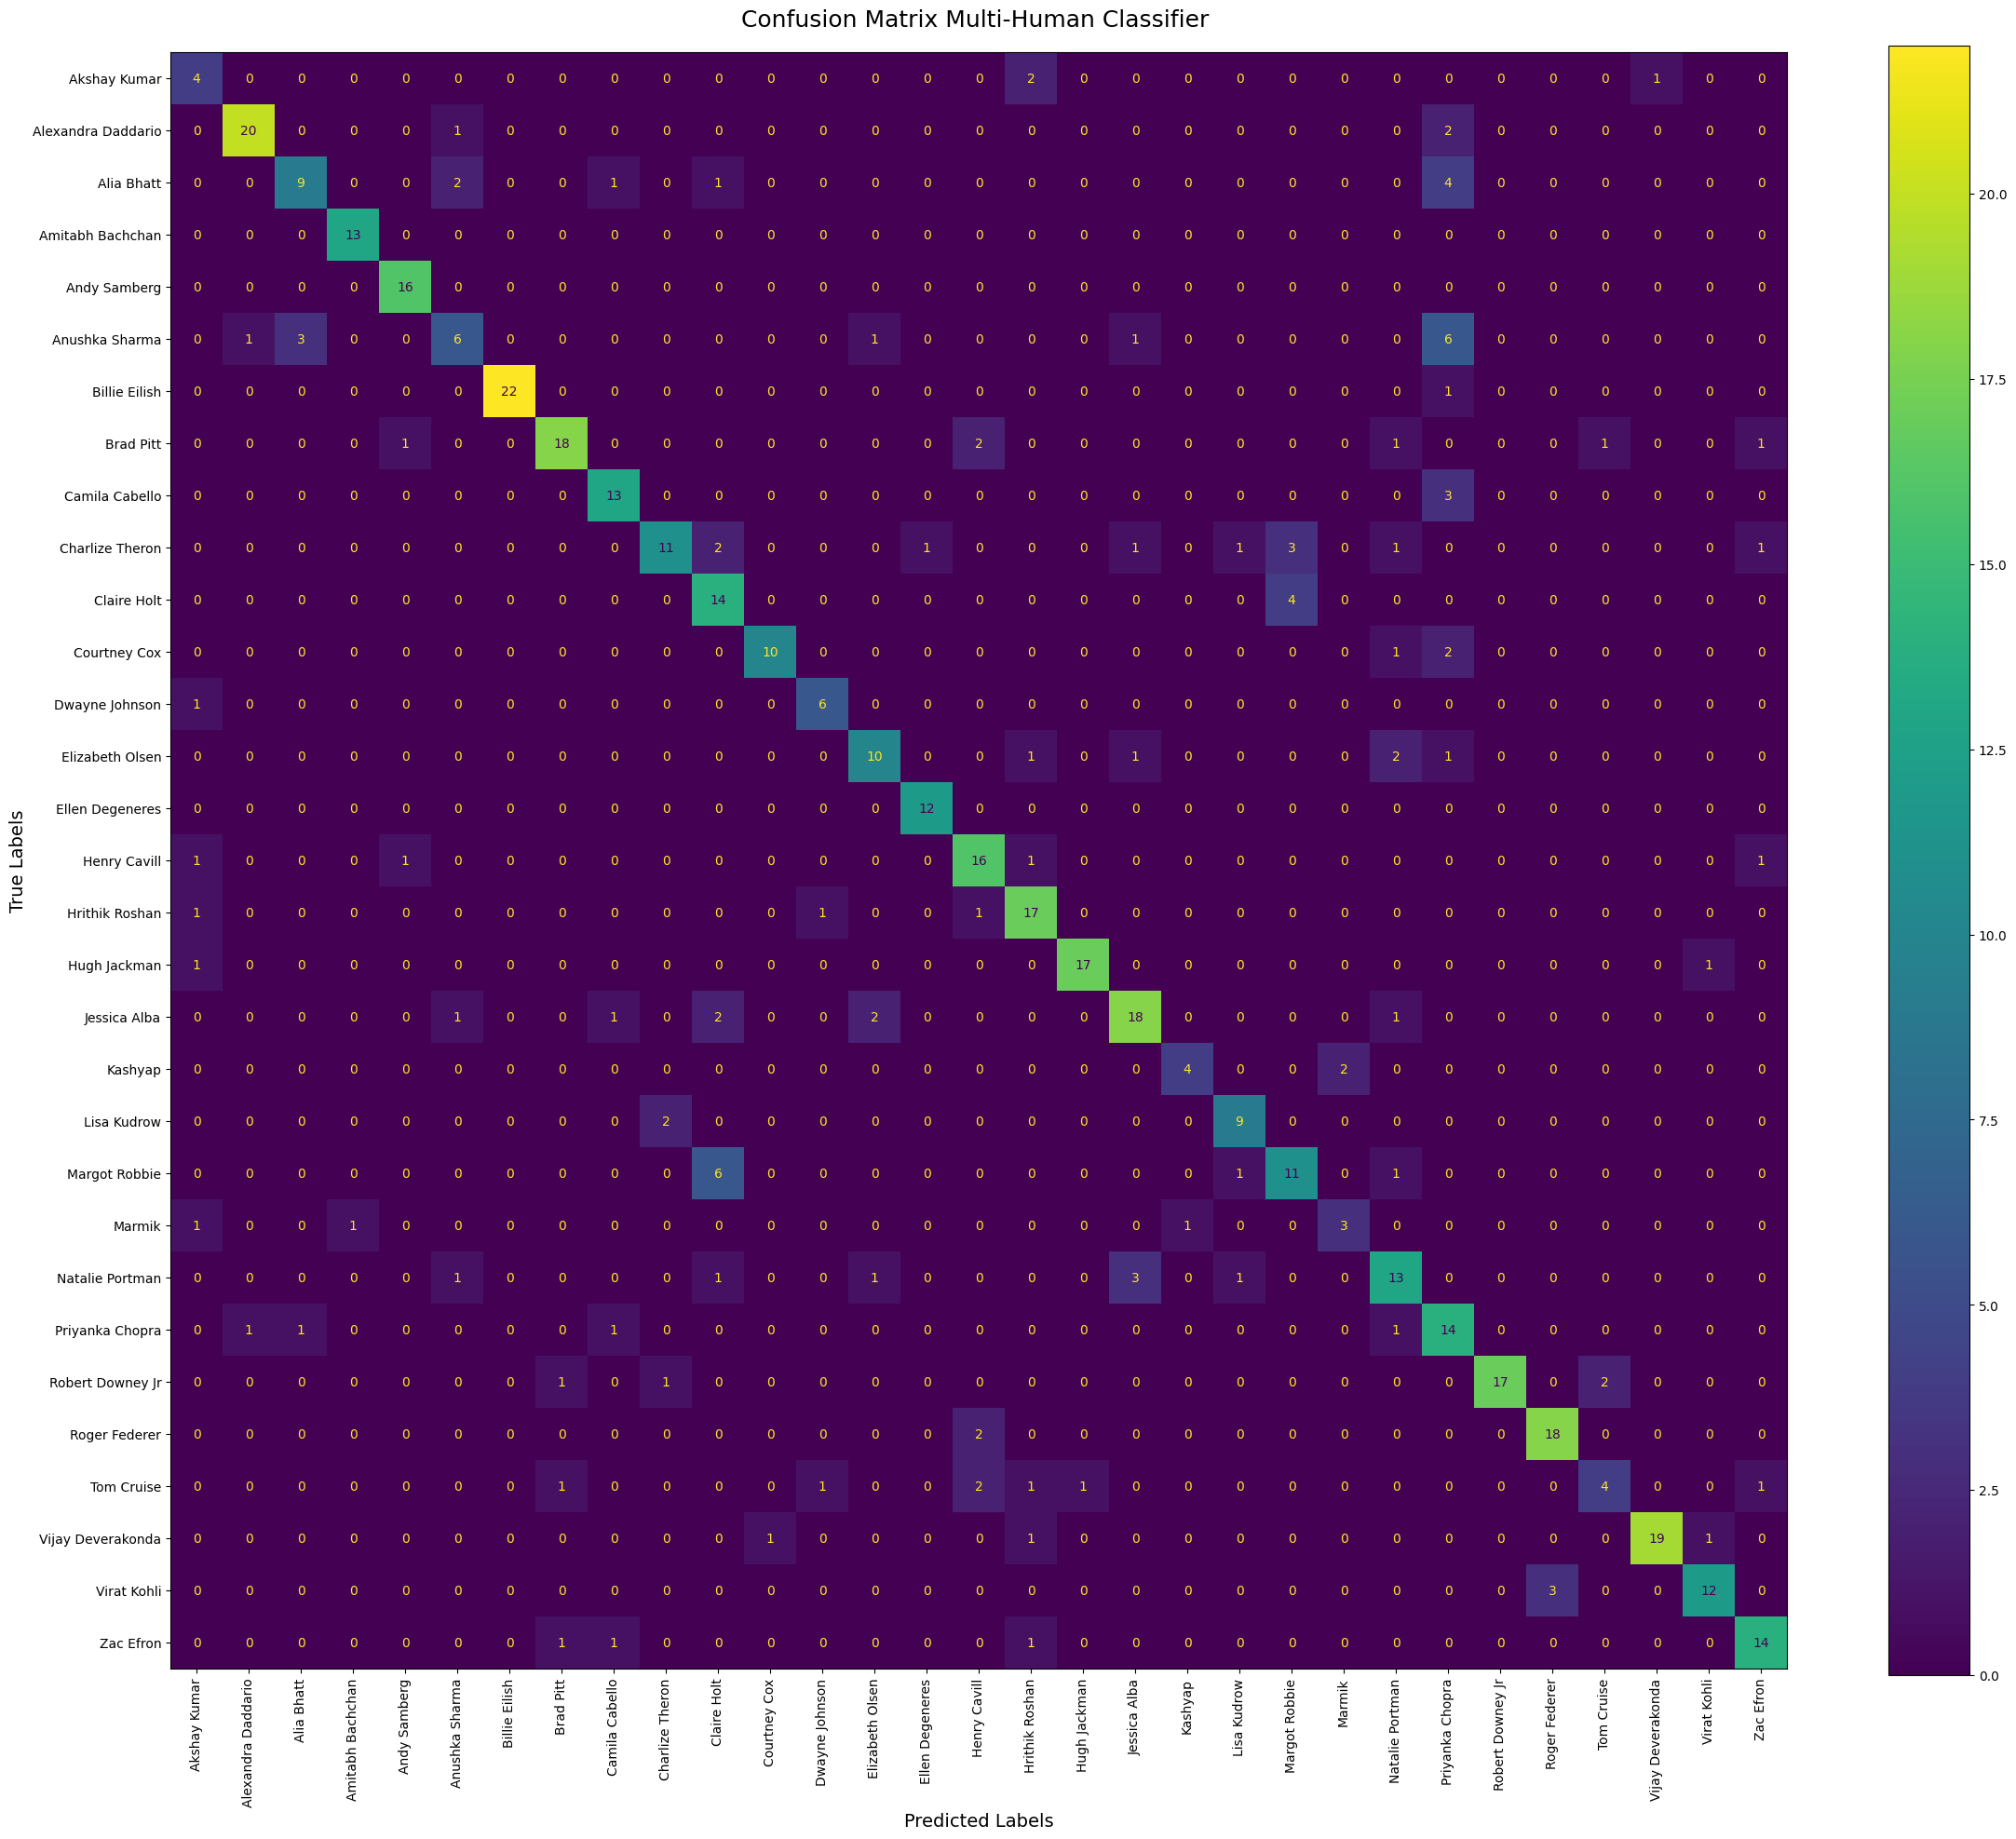

In [ ]:
#confusion matrix using all predicitons vs the true labels
model.eval()
allpredication = []
alllabels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = model(imgs)
        _, preds_batch = torch.max(out, 1)
        allpredication.extend(preds_batch.cpu().numpy())
        alllabels.extend(labels.cpu().numpy())
#large mapping since we have 31 classes
cm = confusion_matrix(alllabels, allpredication, labels=np.arange(len(dataset.classes)))

fig, ax = plt.subplots(figsize=(22, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dataset.classes)
disp.plot(ax=ax, cmap="viridis", colorbar=True)
#rotated x labels to help them fit into plot
plt.xticks(rotation=90, ha='center')
plt.yticks(rotation=0)
plt.subplots_adjust(bottom=0.35, top=0.95, left=0.25, right=1.05)
#used bigger fontsize and pad for clearler names on the plot
plt.title("Confusion Matrix Multi-Human Classifier ", fontsize=18, pad=20)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
#Gradio UI using dataset
classnames = dataset.classes
#converts the uploaded image to tensor similar to our training model,then model logits
def infer(image: Image.Image):
    if image is None:
        return {}
    images = image.convert("RGB")
    x = transform(images).unsqueeze(0).to(device)
#adds nonlinearity activiation function
#determines weather or not a neuron should be activated,whether the input to the work is important or not to predict
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probailities = F.softmax(logits, dim=1).squeeze(0).cpu().numpy() #softmax for probailities

    #k=5 to return top k class label with confidence
    k = 5 if len(classnames) >= 5 else len(classnames)
    top_idx = probailities.argsort()[::-1][:k]
    return {classnames[i]: float(probailities[i]) for i in top_idx}
#UI with the image upload alongside the ranked label output
demo = gr.Interface(
fn=infer,
inputs=gr.Image(type="pil", label="upload a face"),
outputs=gr.Label(num_top_classes=5, label="Prediction (Top-5)"),
title="Multi-Human Classifier ResNet18",
description="upload a face image The app returns the most likely identity with confidence.")
demo.launch(share=True) #allows for a temporarly public link that can be shared


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f850cd0f6ed5b341cb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
